# Music Recommender System via Spotify API

## Overview
Inspired by the movie recommender system we build on homework, we decided to create a music recommender system using real user data from Spotify.

Recommender systems are extremely useful in a variety of IT areas nowadays, such as playlist generators for video and music services like Netflix, YouTube and Spotify, product recommenders for services such as Amazon, or content recommenders for social media platforms such as Facebook and Twitter. 

![title](images/recommender1.png)

Recommendation systems are quite complicated, as the above picture shows. The system we build here is mainly about data collection, data preprocessing, model construction, visualization and analysis.

Common approaches applied to a recommendation system includes collaborative filtering, content-based filtering, and knowledge-based methods. Here we are focusing on the collaborative filtering approach, which conducts recommendation based upon the preferences that other users have indicated for these items. We have tried method used in the course and also another more advanced Collaborative Filtering method often used in business.

## Environment requirement

* Standard Library: 
    * [io](https://docs.python.org/3/library/io.html)
    * [time](https://docs.python.org/3/library/time.html)
    * [json](https://docs.python.org/3/library/json.html)
    * [csv](https://docs.python.org/3/library/csv.html)
    * [pathlib](https://docs.python.org/3/library/pathlib.html)
    * [collections](https://docs.python.org/3/library/collections.html)
    * [itertools](https://docs.python.org/3/library/itertools.html)

* Third Party
    * [numpy](https://numpy.org/)
    * [pandas](https://pandas.pydata.org/pandas-docs/stable/install.html)
    * [matplotlib](https://matplotlib.org/)
    * [requests](http://docs.python-requests.org/en/master/)
    * [spotipy](https://pypi.org/project/spotipy/)
    * [pytorch](https://pytorch.org/)
    * [surprise](http://surpriselib.com/)
    * [sklearn](https://scikit-learn.org/stable/install.html)

Import all of the packages we need.

In [3]:
import spotipy
import spotipy.oauth2 as oauth2
import io, time, json
import requests
import csv
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
from torch import optim
from torch import nn
from torch.utils.data import Dataset as DS
from torch.utils.data import DataLoader
from sklearn import model_selection
from collections import Counter, defaultdict
from itertools import zip_longest
from surprise import SVD
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, cross_validate, train_test_split

## Data scraper via Spotify API
Spotify provide us an [endpoint](https://developer.spotify.com/documentation/web-api/reference/playlists/get-list-users-playlists/) where we can get a list of user's playlists given the user_id. Our intuition is, all the tracks from the user's playlists should be ones that user enjoys the most. In order to assign a score to each track indicatng how much the user like that song, we considered user's total number of brodcast times, whether the user put this song to his 'fav' playlist etc. However, Spotify hide these information from us in order to protect user privacy. So at last we count the number of times a track occured in the user's playlists as an indicator of how much the user like that song. 
### Here are two helper functions that 
1. Read client id and client secret given file path.
2. Generate API token given client id and client secret.

In [3]:
def read_client_info(filepath):
    """
    Read the Spotify Client ID from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        client_id (string): The client_id
    """
    return Path(filepath).read_text().strip()

def generate_token():
    """
    Generate the token from client_id and client_secret
    
    Returns:
        token(string): Token used to access spotify API
    """
    credentials = oauth2.SpotifyClientCredentials(
        client_id=read_client_info("client_id.txt"),
        client_secret=read_client_info("client_secret.txt"))
    token = credentials.get_access_token()
    
    return token

### Helper functions for data scraping
To build a real music recommender system, we need a list of users, with each user a list of favorite songs and a score indicating how much the user like each song. So we need a few helper functions that:
1. Given playlist id/uri, return all the tracks in this playlist.
2. Given user id, return all the public playlists this user created or collected. 

In [119]:
def get_response(token, uri):
    """
    Generate response of http request
    
    Args:
        token(string): Token used to access spotify API
        uri(string): Requested uri
        
    Returns:
        status_code(int): Status code of the request
        txt(string): Json-formatted user's playlist information
    """
    headers = {'Authorization': 'Bearer %s' % token}
    rsp = requests.get(uri, headers=headers)
    
    return rsp.status_code, rsp.text

def get_tracks_from_playlist(token, playlist_uri):
    """
    Make an authenticated request to the Spotify API to get all the tracks in a public playlist.
    
    Args:
        token(string): Token used to access spotify API
        playlist_uri(string): Requested uri
        
    Returns:
        res(list): A list of tracks in a playlist
    """
    res = []
    status_code, txt = get_response(token, playlist_uri)
    if status_code == 200:
        d = json.loads(txt)
        tracks = d['tracks']
        while True:
            for item in tracks['items']:
                if item['track']:
                    track_name = item['track']['name']
                    res.append(track_name)
            if tracks['next']:
                tracks = spotify.next(tracks)
            else:
                break
    return res

def get_users_public_playlist(token, user_id):
    """
    Make an authenticated request to the Spotify API to get user's public playlists.
    
    Args:
        token(string): Token used to access spotify API
        user_id(string): User's id
        
    Returns:
        status(int): Status of the request
        res(list): The list of a user's all tracks
    """
    res = []
    nxt = "https://api.spotify.com/v1/users/" + user_id + "/playlists/?limit=50&offset=0"
    while nxt:
        status, txt = get_response(token, nxt)
        if status == 200:
            d = json.loads(txt)
            nxt = d['next']
            items = d['items']
            for item in items:
                tmp_d = {}
                tmp_d['playlist_id'] = item['id']
                tmp_d['playlist_name'] = item['name']
                track_names = get_tracks_from_playlist(token,item['href'])
                tmp_d['track_names'] = track_names
                res.append(tmp_d)
        else:
            return status, res
    return status, res

def transform_format(_id, playlists):
    """
    Transform the format of collected user data
    
    Args:
        _id(string): user's id
        playlists(list): The list of a user's all tracks
        
    Returns:
        tuple(list[id], list[tracks], list[frequences])
    """
    tracks = []
    for d in playlists:
        tracks += d['track_names']
    c = Counter(tracks)
    
    return [_id] * len(c.keys()), list(c.keys()), list(c.values())

- Now we can start scraping data! We found that a large amount of user ids start with "11100563xxx". So we use this pattern to get a list of user data.  
- For each user id, if the request return status code "200" and the user has at list one playlist, we get all the tracks and count the frequency for each track.  
- At last, we are able to get data from 266 users and 173559 songs in total

In [120]:
# Get token
token = generate_token()
spotify = spotipy.Spotify(auth=token)

ids = []
track_names = []
freqs = []
start = "11100563"
count = 0

# Scrape user tracks 
for i in range(10):
    for j in range(10):
        for k in range(10):
            user_id = start + str(i) + str(j) + str(k)
            status, playlists = get_users_public_playlist(token, user_id)
            if playlists:
                print(count)
                tmp_ids, tmp_tracks, tmp_freqs = transform_format(count, playlists)
                ids += tmp_ids
                track_names += tmp_tracks
                freqs += tmp_freqs
                assert len(ids) == len(track_names)
                count += 1
            time.sleep(0.2)

# Convert the data into pandas dataframe
df = pd.DataFrame({
    "user_id": ids,
    "track_name": track_names,
    "freq": freqs
})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


Then we store dataframe to a csv for later usage.

In [ ]:
df.to_csv('spotify_266users.csv', index=False)

## Data Preprocessing

Now we have the data, we can do some visualization and preprocessing to convert data to the format we want to use.

Read the dataframe from csv file and see how many NaNs we have.

In [45]:
df = pd.read_csv("spotify_266users.csv")
df.isnull().sum()

user_id        0
track_name    14
freq           0
dtype: int64

After droping NaNs, we can print the dataframe to see what it looks like and get min / max frequency.

In [46]:
df = df.dropna()
print(df)
print(f"min freq: {df.freq.min()}, max freq: {df.freq.max()}")

        user_id                    track_name  freq
0             0                        你不知道的事     1
1             0                           那些年     1
2             0                         我們不一樣     1
3             0                          帥到分手     1
4             0                            王妃     1
...         ...                           ...   ...
173554      266                    I Remember     1
173555      266                       October     1
173556      266  Faxing Berlin - Original Mix     1
173557      266                   Not Exactly     1
173558      266    You And I - Deadmau5 Remix     1

[173545 rows x 3 columns]
min freq: 1, max freq: 44


We can see every piece of data is (user_id, track_name, freq).

Then we plot a histogram of the frequency to see the distribution and also help us transform dataset and find outliers or anamolies.

total rows: 173545, number of unique tracks: 107474, number of users: 267


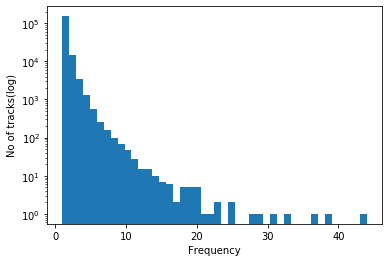

In [47]:
def show_stat(df):
    """
    Visualize the stats of track-frequency. Since we are visualizing every row of dataframe, 
    there are some duplicate tracks for different users.
    
    Args:
        df(DataFrame): Dataframe storing the data
    """
    tracks = set(df["track_name"])
    print(f'total rows: {df.shape[0]}, number of unique tracks: {len(tracks)}, number of users: {df["user_id"].to_numpy()[-1] + 1}')
    plt.hist(df.freq, bins=df.freq.max())
    plt.yscale('log', nonposy='clip')
    plt.ylabel('No of tracks(log)')
    plt.xlabel('Frequency')
    plt.show()

show_stat(df)

Seems like the distribution is exponential. We need to consider cutting the frequency at around 23 and remove all data after that level to eliminate outliers. More importantly, we can see that tracks whose freqency is 1 dominate the model severely. So we need to figure out a way to handle such skewed data to avoid the model to always predict freq = 1. Let's do furthur statistical analysis.

In [48]:
# Count the total frequency for unique tracks
total_freq = defaultdict(int)
trackname_np = df['track_name'].to_numpy()
freq_np = df['freq'].to_numpy()
for track_name, fre in zip(trackname_np, freq_np):
    total_freq[track_name] += fre
print(f'''number of rows of which frequency is 1: {sum(freq_np == 1)}, 
number of rows of which frequency is 2: {sum(freq_np == 2)}, 
number of rows of which frequency is 3: {sum(freq_np == 3)}
number of tracks that occured only once in the dataset: {sum(np.array(list(total_freq.values())) == 1)}''')

# Count the number of tracks whose users all have frequency 1 for it
track_freq1_count = defaultdict(int)
for track_name, freq in zip(trackname_np, freq_np):
    if freq == 1:
        track_freq1_count[track_name] += 1
        
sums = 0
for track_name in track_freq1_count.keys():
    if total_freq[track_name] == track_freq1_count[track_name]:
        sums += 1
print("number of tracks whose users all have frequency 1:", sums)

number of rows of which frequency is 1: 152371, 
number of rows of which frequency is 2: 15122, 
number of rows of which frequency is 3: 3490
number of tracks that occured only once in the dataset: 77386
number of tracks whose users all have frequency 1: 92222


There are 77386 tracks occured only once in the dataset, which means they are only liked by one user. What's more, even if some tracks appear multiple times, all of the users that like it only like it once. There are totally 92222 these two kinds of data. These tracks are highly unlikely to be the one that may recommend to other users. So we clear them all to avoid unbalanced dataset. Besides, we also clear outliers whose frequency is greater than or equal to 24.

After filtering, let's show the stats again.

total rows: 54583, number of unique tracks: 15248, number of users: 267


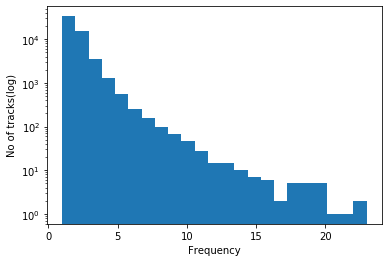

number of rows of which frequency is 1: 33418, 
number of rows of which frequency is 2: 15122, 
number of rows of which frequency is 3: 3490
number of tracks that occured only once in the dataset: 0


In [49]:
trackname_to_remove = set([key for key, value in track_freq1_count.items() if total_freq[key] == value])
df = df[~df['track_name'].isin(trackname_to_remove)]
df = df[~df['freq'].ge(24)]
show_stat(df)

total_freq = defaultdict(int)
trackname_np = df['track_name'].to_numpy()
freq_np = df['freq'].to_numpy()
for track_name, fre in zip(trackname_np, freq_np):
    total_freq[track_name] += fre
print(f'''number of rows of which frequency is 1: {sum(freq_np == 1)}, 
number of rows of which frequency is 2: {sum(freq_np == 2)}, 
number of rows of which frequency is 3: {sum(freq_np == 3)}
number of tracks that occured only once in the dataset: {sum(np.array(list(total_freq.values())) == 1)}''')

The data looks much better now!

Let's wrap the data, map track_name to index and then split them into train and test dataset before feeding into the model.

In [50]:
class CF_Data():
    """
    class used for getting data for different models, and mapping the track_name to index.
    """
    def __init__(self, df):
        """
        Store the data inside the class, and map track_name to index.
        
        Args:
            df(DataFrame): dataframe containing data
        """
        self.df = df
        tracks = set(self.df["track_name"])
        self.track2idx, self.idx2track = {}, {}
        for idx, track in enumerate(tracks):
            self.track2idx[track] = idx
            self.idx2track[idx] = track
        
        self.df.track_name = self.df.track_name.apply(lambda x: self.track2idx[x])
        self.user_id = self.df.user_id.to_numpy().astype(np.int64)
        self.track_name = self.df.track_name.to_numpy().astype(np.int64)
        self.freq = self.df.freq.to_numpy().astype(np.float32)
    
    def get_traditional_data(self, test_size):
        """
        Get the data for traditional model.
        
        Args:
            test_size(float): Propotion of test data
            
        Returns:
            train_data, test_data(surprise.Dataset): Train and test data
        """
        data = Dataset.load_from_df(self.df, reader=Reader())
        train_data, test_data = train_test_split(data, test_size=0.2)
        
        return train_data, test_data

    def get_dl_data(self, test_size):
        """
        Get the data for deep learning model.
        
        Args:
            test_size(float): Propotion of test data
            
        Returns:
            tuple of train and test data
        """
        userid_train, userid_test, trackname_train, trackname_test, freq_train, freq_test = \
            model_selection.train_test_split(cf_data.user_id, cf_data.track_name, cf_data.freq, test_size=0.2)
        
        return userid_train, userid_test, trackname_train, trackname_test, freq_train, freq_test

Create a cf_data object, and specific the test data size.

In [51]:
cf_data = CF_Data(df)
test_size = 0.2

OK, now we are ready to train and test 2 CF models. The first one is what we learned on the course that uses matrix factorization. We use factory code from suprise package to achieve this. For another approach, we utilize deep learning to learn data for recommendation.

## Traditional collaborative filtering

Now let's do the recommendation using matrix factorization. First load the data, then use the train data to
learn the matrix, and finally evaluate the accuracy on the test data.

In [52]:
# Load data
train_data, test_data = cf_data.get_traditional_data(test_size)
# Algorithm
algo = SVD()
# Train
algo.fit(train_data)
# Test
predictions = algo.test(test_data)
# Evaluate
accuracy.mse(predictions)

MSE: 1.1889


1.1889297004451191

## Collaborative filtering with Deep learning approach

- This approach trains 2 different embedding representations for users and tracks seperately. To get a prediction value about how much user m likes track n, we concatenate 2 embedding vectors and send it to a neural network.
<img src="images/dl2.png">  

Let's first define our network

In [53]:
class EmbeddingNet(torch.nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
        n_users:            
            Number of unique users in the dataset.

        n_tracks: 
            Number of unique tracks in the dataset.
            
        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply after embeddings layer.

        hidden:
            a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            a list of integers defining the dropout 
            layers rates applyied after each of hidden layers.
            
    """
    def __init__(self, n_users, n_tracks,
                 n_factors_user=50, n_factors_track=50, embedding_dropout=0., 
                 hidden=[10], dropouts=[0.2]):
        
        super().__init__()
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            
            Args:
                n_in(int): Input dimension
            """
            nonlocal hidden, dropouts
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors_user)
        self.m = nn.Embedding(n_tracks, n_factors_track)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors_user + n_factors_track)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, tracks):
        """
        Forward function
        
        Args:
            users(B * 1): users' id
            tracks(B * 1): tracks' id
        """
        features = torch.cat([self.u(users), self.m(tracks)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = self.fc(x)
        
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        
        Args:
            m: Network layer
        """
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)

Let's initialize our network and take a look at it.

In [54]:
net = EmbeddingNet(cf_data.user_id[-1] + 1, len(cf_data.track2idx), n_factors_user = 50, n_factors_track=50, hidden= [32, 32], dropouts = [0.1,0.1])
net

EmbeddingNet(
  (u): Embedding(267, 50)
  (m): Embedding(15248, 50)
  (drop): Dropout(p=0.0, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

Then we create a customized dataset class via pytorch

In [55]:
class MusicDataset(DS):
    """
    music rating dataset.
    """
    def __init__(self, user_id, track_name, freq):
        self.user_id = user_id
        self.track_name = track_name
        self.freq = freq

    def __len__(self):
        return len(self.user_id)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.user_id[idx], self.track_name[idx], self.freq[idx]

Now we write two functions repectively for training and testing the model.

In [56]:
def train_epoch(net, optimizer, loader, criterion, device):
    """
    Train the network for one epoch.
    
    Args:
        net: Neural network model
        optimizer: Model optimizer
        loader: Dataloader
        Criterion: Loss criterion
        Device: device
        
    Returns:
        Average MSE loss for every data
    """
    running_loss = 0
    total_num = 0
    for i, batch in enumerate(loader):
        user_id, track_name, freq = batch
        total_num += len(user_id)
        user_id = user_id.to(device)
        track_name = track_name.to(device)
        freq = freq.to(device)
        optimizer.zero_grad()
        out = net(user_id, track_name)
        loss = criterion(out.view(-1), freq, device)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 1:
            cur = running_loss / i
            print(f"loss:{cur:.2f}")
    
    return running_loss / total_num

def evaluate_epoch(net, loader, device):
    """
    Test the network.
    
    Args:
        net: Neural network model
        loader: Dataloader
        Device: device
        
    Returns:
        Average MSE loss for every data
    """
    running_loss = 0
    total_num = 0
    for batch in loader:
        user_id, track_name, freq = batch
        total_num += len(user_id)
        user_id = user_id.to(device)
        track_name = track_name.to(device)
        freq = freq.to(device)
        with torch.no_grad():
            out = net(user_id, track_name)
            loss = criterion(out.view(-1), freq, device)
        running_loss += loss.item()
    
    return running_loss / total_num # MSE

Although we have preprocessed the data to remove some imbalance, it is still kind of imbalanced, so we tried add loss weight to handle this problem. The label with less data tends to have a higher loss weight. We achieve this by counting.

In [86]:
freq_max = df.freq.max()
weight_dict = {}
freq_count = Counter(df["freq"])
for freq, cnt in freq_count.items():
    weight_dict[freq] = 1 / cnt

weight_dict

{1: 2.992399305763361e-05,
 2: 6.612881893929374e-05,
 3: 0.00028653295128939826,
 8: 0.010416666666666666,
 10: 0.02127659574468085,
 7: 0.0064516129032258064,
 5: 0.0017985611510791368,
 4: 0.0007830853563038371,
 6: 0.003937007874015748,
 9: 0.014925373134328358,
 12: 0.06666666666666667,
 11: 0.037037037037037035,
 19: 0.2,
 16: 0.16666666666666666,
 14: 0.1,
 13: 0.06666666666666667,
 15: 0.14285714285714285,
 20: 0.2,
 17: 0.5,
 23: 0.5,
 18: 0.2,
 21: 1.0,
 22: 1.0}

Here is our customized weighted MSE Loss function.

In [58]:
class Weighted_MSELoss(torch.nn.Module):
    def __init__(self, weight_dict):
        self.weight_dict = weight_dict
        super(Weighted_MSELoss, self).__init__()
    def forward(self, output, target, device):
        out = (output-target)**2
        weights = torch.tensor([weight_dict[int(f)] for f in target]).to(device)
        out = out * weights
        loss = out.sum()
        return loss

Now, it's time we start training !
First set up the data, network and hyperparameters.

In [59]:
# Get data
userid_train, userid_test, trackname_train, trackname_test, freq_train, freq_test = cf_data.get_dl_data(test_size)

# Define hyperparameters and variables
bs = 128
lr = 1e-3
wd = 1
n_epochs = 10
patience = 2
no_improvements = 0
best_loss = np.inf

# Define network
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
criterion = Weighted_MSELoss(weight_dict).to(device)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

# Create dataset and dataloader
train_dataset = MusicDataset(userid_train, trackname_train, freq_train)  
valid_dataset = MusicDataset(userid_test, trackname_test, freq_test)
train_loader = DataLoader(
        train_dataset, batch_size=bs, shuffle=True, num_workers=4
)
valid_loader = DataLoader(
        valid_dataset, batch_size=bs, shuffle=False, num_workers=4
)

In [60]:
# Train and test
for epoch in range(n_epochs):
    print(f"----- Epoch {epoch} -----")
    net.train()
    train_loss = train_epoch(net, optimizer, train_loader, criterion, device)
    print(f"train MSE loss: {train_loss:.2f}")
    net.eval()
    eval_loss = evaluate_epoch(net, valid_loader, device)
    print(f"Validation MSE loss: {eval_loss:.2f}")
    # Early stopping
    if eval_loss < best_loss:
        best_loss = eval_loss
        no_improvements = 0
        print(f"Saving new best model (epoch {epoch} loss {eval_loss})")
        torch.save(net.state_dict(), 'model.pt')
    else:
        no_improvements += 1
    if patience < no_improvements:
        print(f'early stopping after epoch {epoch}')
        break

----- Epoch 0 -----
loss:757.57
loss:255.33
loss:200.21
loss:180.56
train MSE loss: 1.36
Validation MSE loss: 1.12
Saving new best model (epoch 0 loss 1.1246447925265373)
----- Epoch 1 -----
loss:293.83
loss:141.21
loss:145.28
loss:140.35
train MSE loss: 1.10
Validation MSE loss: 1.12
Saving new best model (epoch 1 loss 1.120312877591084)
----- Epoch 2 -----
loss:430.09
loss:138.77
loss:142.18
loss:139.55
train MSE loss: 1.09
Validation MSE loss: 1.12
----- Epoch 3 -----
loss:143.36
loss:144.03
loss:134.36
loss:137.92
train MSE loss: 1.08
Validation MSE loss: 1.12
Saving new best model (epoch 3 loss 1.1196969509168435)
----- Epoch 4 -----
loss:546.14
loss:132.32
loss:135.02
loss:138.61
train MSE loss: 1.08
Validation MSE loss: 1.12
----- Epoch 5 -----
loss:169.44
loss:132.90
loss:136.79
loss:136.15
train MSE loss: 1.06
Validation MSE loss: 1.12
Saving new best model (epoch 5 loss 1.1187423355928585)
----- Epoch 6 -----
loss:311.95
loss:134.30
loss:136.37
loss:138.43
train MSE loss: 1.0

We can see the model is a little better than the traditional method in terms of MSE loss.

Now let's try to use this model to recommend music for users. We can choose a user to recommend for, and then calculate the prediction scores for all tracks, then get the top K tracks recommended for this user.

In [87]:
# Choose a user and all tracks, input to the network, and generate prediction output.
user_id = 10
user_tracks = cf_data.track_name[cf_data.user_id == user_id]
user_freqs = cf_data.freq[cf_data.user_id == user_id]
all_tracks = list(set(cf_data.track_name))
out = net(torch.tensor([user_id] * len(all_tracks)).to(device), torch.tensor(all_tracks).to(device))

# Select the top 5 recommended tracks to print
k = 5
topk, indices = torch.topk(out.view(-1), k)
recommend_tracks = [cf_data.idx2track[all_tracks[idx]] for idx in indices]
print(f"Top {k} tracks recommended to user {user_id} are {recommend_tracks}")

Top 5 tracks recommended to user 10 are ['Hello', 'The Scientist', 'Let All Mortal Flesh Keep Silence', 'Body On Me - Main', 'Deuces Remix']


Since we are using a collaborative filtering method, the recommended tracks should be based on other users' preferences, which means they should be some poplular tracks. Let's show the recommended tracks and compare them with the whole track set.

Frequency of top 5 tracks recommended [96, 63, 17, 15, 20]
Max frequency 96


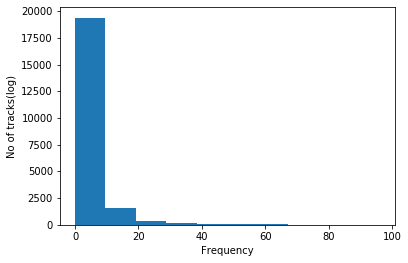

In [85]:
# Visualize the total frequency in the original data for these recommend tracks.
recommend_tracks_freq = [total_freq[track] for track in recommend_tracks]
print(f"Frequency of top {k} tracks recommended {recommend_tracks_freq}")

# Visualize the total frequency distribution in the track set.
print(f"Max frequency of the whole track set: {max(total_freq.values())}")
plt.hist(total_freq.values())
plt.ylabel('No of tracks(log)')
plt.xlabel('Frequency')
plt.show()

We can see that one of the recommended tracks is the track with highest frequencies, and the other four tracks also have relatively high frequency, which means these tracks are popular. 
This shows our recommendation system is able to recommend tracks to a specific user based on other users' perferrences!

## Summary

In this project, we gradually build a music recommendation system. Our work includes:

1. Scrape the users' data using spotify API, and extract every user's information.
2. Preprocess the data, including formatting to structured data, reducing the imbalancing, and index mapping.
3. Build a traditional collaborative filtering model.
4. Build a deep learning collaborative filtering model.
5. Use the built model to recommend tracks for users, and visualize the recommendation results.

There are still some spaces for the improvement of our project. For example, the data we collect could include other features, our model could be further tuned, and so on.

Without any exaggeration, we really learn a bunch of stuff by building this whole pipeline. We realize data science is more about practicing than thinking. Maybe it's easy to think of some ideas to deal with the data, but correctly implementing them and producing reasonable results is definitely another thing. Thank you professor Kolter and amazing TAs! We have learned a lot of things in this course, and we know there is a long way to go. But we will stick to it and try our best to become excellent data scientists!

## Reference

https://spotipy.readthedocs.io/en/latest/  
http://surpriselib.com/  
https://pytorch.org/  
https://matplotlib.org/  
https://en.wikipedia.org/wiki/Recommender_system  
http://www.datasciencecourse.org/slides/recommender.pdf